In [46]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn import  model_selection, linear_model
from sklearn.metrics import mean_squared_log_error, recall_score
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot

import os
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
data_dir = '../data/'

In [62]:
def rmsle(est, x, y_test):
    """
    Метрика rmsle
    """

    predict = est.predict(x)
    predict = [x if x > 0 else 0 for x in predict]
    return np.sqrt(mean_squared_log_error(y_test, predict ))


def regr_score(x_train, y_train, regr, scoring):
    """
    Расчет кроссвалидации

    """
    scores = cross_validate(regr, 
                            x_train, 
                            y_train, 
                            scoring=scoring,
                            cv=5, 
                            return_train_score=False)
    
    scores_list = scores[list(scores.keys())[-1]]
    print(scores_list)
    print(f'mean score -- {np.mean(scores_list)}')
    
    
def get_data():
    df_x = pd.read_csv(f'{data_dir}/train.csv')
    df_x = df_x.fillna(-1)
        
    y = df_x['label']
    df_x = df_x.drop(['status', 'short', 'activity_title', 'title_activity_type',
                      'activity_description', 'title_direction', 'comment_direction'], 
                     axis=1)
    return df_x, y


### Read data

In [63]:
df_x, y = get_data()
print(df_x.shape)
print(len(y))
print(df_x.columns)

(13000, 12)
13000
Index(['id_bet', 'run_id', 'user_id', 'label', 'direction_id', 'activity_id',
       'size_max', 'size_min', 'is_educational', 'is_checkin_required',
       'activity_type_id', 'main_competence_id'],
      dtype='object')


In [64]:
x_train = np.array(df_x)
y_train = np.array(y)

In [65]:
# Посмотрим, какие есть файлы и положим их в словарь
dfs = {}
for i, x in enumerate(os.listdir(data_dir)):
    file_name = x.split('.')[0]
    print(f'{i} -- {file_name}')
    dfs[file_name] = pd.read_csv(f'{data_dir}/{x}')

0 -- activity_author
1 -- activity_tag
2 -- activity_track
3 -- author
4 -- competence
5 -- competence_level
6 -- competence_type
7 -- event
8 -- place
9 -- role
10 -- sample_submission
11 -- test
12 -- time_slot
13 -- track
14 -- train
15 -- user_role
16 -- user_tag


### Correlation

c:\users\roman\anaconda3\envs\py36\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


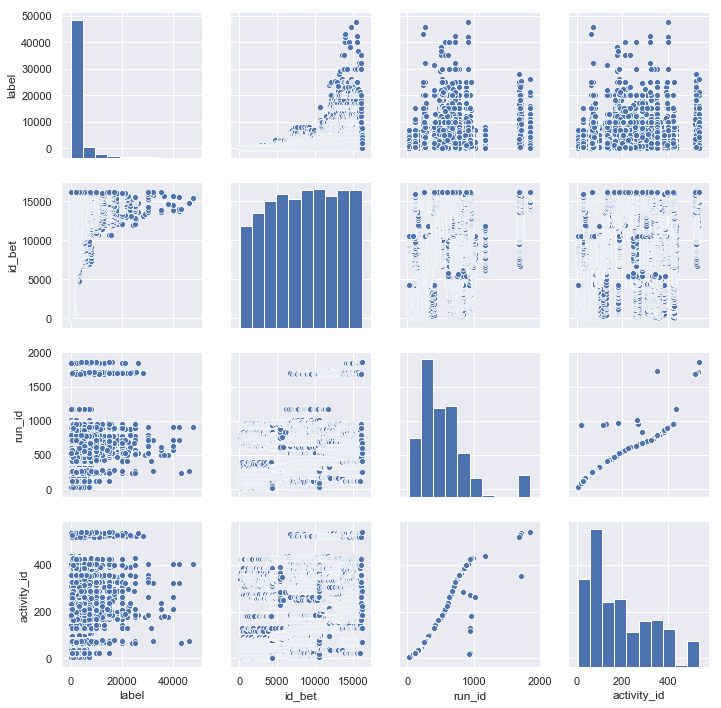

In [66]:
sns.set()
cols = ['label', 'id_bet', 'run_id', 'activity_id']
sns.pairplot(df_x[cols], size = 2.5)
plt.show();

In [70]:
df_x = df_x.drop(['label'],axis=1)

### Simple prediction
Для начала попробуем самые простые модели

In [71]:
regr = DummyRegressor(strategy='mean')
regr_score(x_train, y_train, regr, rmsle)
print()

[3.17623168 2.64802335 1.97579148 1.95395719 1.93442136]
mean score -- 2.337685013625203



In [72]:
regr = DummyRegressor(strategy='median')
regr_score(x_train, y_train, regr, rmsle)
print()


[2.28039206 1.64154422 1.45836226 1.9740166  2.50493593]
mean score -- 1.97185021481104



In [73]:
regr = KNeighborsRegressor()
regr_score(x_train, y_train, regr, rmsle)

[1.11206824 0.92112649 0.71328207 0.79844997 0.66660475]
mean score -- 0.8423063055145237


Лучшее качество дал алгоритм ближайших соседей.

### Drop outliers


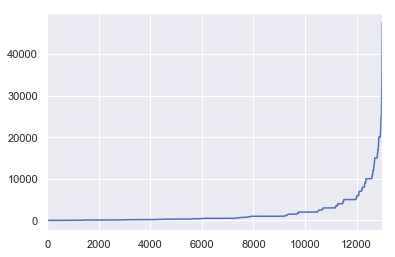

In [74]:
pd.Series(sorted(y_train)).plot()

Видно, что есть выбросы.


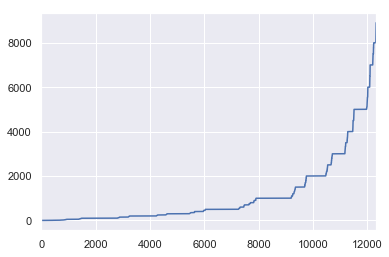

In [75]:
pd.Series(sorted([x for x in y_train if x < np.quantile(y_train, 0.95)])).plot()

In [76]:
# Формирование новой выборки без выбросов
x_train = np.array(df_x)
y_train = np.array(y)

x_train = x_train[[True if x < np.quantile(y_train, 0.95) else False for x in y_train]]
y_train = [x for x in y_train if x < np.quantile(y_train, 0.95)]


Посмотрим качество моделей

In [77]:
regr = DummyRegressor(strategy='mean')
regr_score(x_train, y_train, regr, rmsle)
print()

regr = DummyRegressor(strategy='median')
regr_score(x_train, y_train, regr, rmsle)
print()

regr = KNeighborsRegressor()
regr_score(x_train, y_train, regr, rmsle)

regr = lgb.LGBMRegressor()
regr_score(x_train, y_train, regr, rmsle)
print()

[2.71190343 2.31330984 1.60983129 1.75684083 1.77779191]
mean score -- 2.033935461952158

[1.98036921 1.62175819 1.47492428 1.8099698  2.18064734]
mean score -- 1.8135337643858425

[1.31851903 1.4221127  1.60173555 1.82461886 1.85278949]
mean score -- 1.6039551248369093
[1.51084194 1.40883955 1.44891176 1.66332082 1.75189662]
mean score -- 1.556762137280378



### One Hot Encoding

In [ ]:
x_train = np.array(df_x)
y_train = np.array(y)

print(x_train.shape)

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(x_train)
x_train = enc.transform(x_train).toarray()

print(x_train.shape)

Добавим дополнительные данные

In [78]:
x_train = np.array(df_x)
y_train = np.array(y)


df_tmp = pd.merge(df_x, dfs['activity_author'].groupby('activity_id').count().reset_index(),  
                  how='left', 
                  left_on='activity_id', right_on='activity_id', 
                  suffixes=('_x', 'activity_author'))

df_tmp = pd.merge(df_tmp, dfs['event'].groupby('run_id').count().reset_index(),  
                  how='left', 
                  left_on='run_id', right_on='run_id', 
                  suffixes=('_x', '_event'))

df_tmp = pd.merge(df_tmp, dfs['user_role'].drop_duplicates('user_id'),
                  how='left', 
                  left_on='user_id', right_on='user_id', 
                  suffixes=('_x', '_event'))



In [79]:
regr = lgb.LGBMRegressor()
regr_score(df_tmp, y_train, regr, rmsle)
print()



[1.63359241 1.86787261 1.53655134 2.04989471 1.8232366 ]
mean score -- 1.78222953355823



In [80]:
print(df_tmp.shape)
print(len(y))

df_tmp = df_tmp.fillna(-1)
x_train = np.array(df_tmp)
y_train = np.array(y)

x_train = x_train[[True if x < np.quantile(y_train, 0.95) else False for x in y_train]]
y_train = [x for x in y_train if x < np.quantile(y_train, 0.95)]

print(x_train.shape)
print(len(y_train))

(13000, 16)
13000
(12320, 16)
12320


In [81]:
regr = lgb.LGBMRegressor(n_estimators=60, num_leaves=39)
regr_score(x_train, y_train, regr, rmsle)
print()


[1.38537005 1.34445554 1.44409099 1.67759821 1.750824  ]
mean score -- 1.5204677586549424



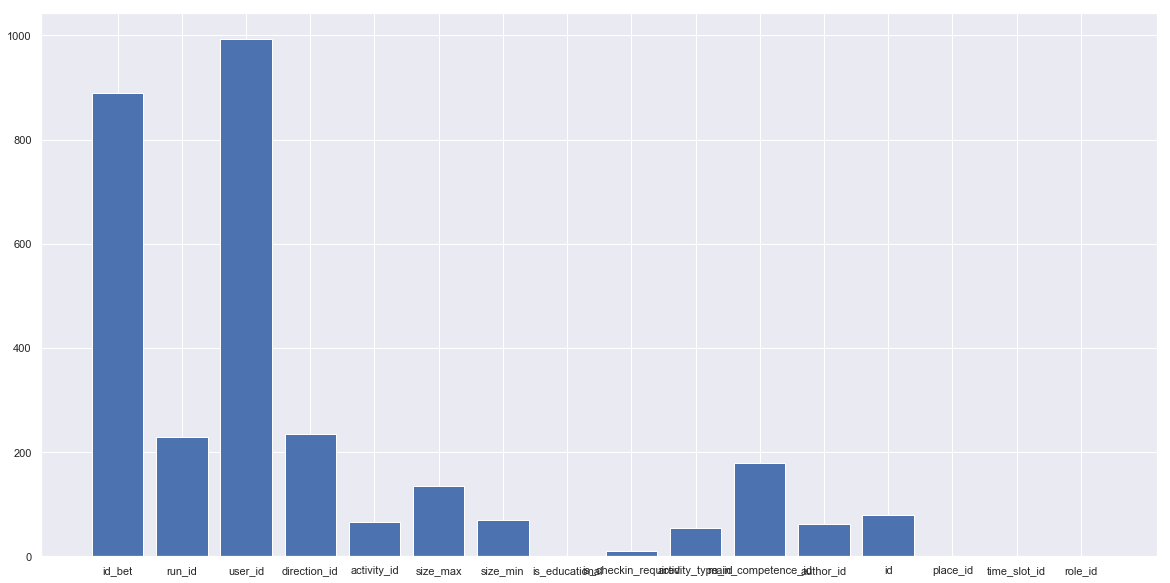

In [82]:
regr = lgb.LGBMRegressor()
regr.fit(x_train, y_train)
pyplot.figure(figsize=(20,10))
pyplot.bar(df_tmp.columns, regr.feature_importances_)
pyplot.show()

### Predict

Сделаем сабмит

In [40]:
df_tmp = pd.merge(df_x, dfs['activity_author'].groupby('activity_id').count().reset_index(),  
                  how='left', 
                  left_on='activity_id', right_on='activity_id', 
                  suffixes=('_x', 'activity_author'))

df_tmp = pd.merge(df_tmp, dfs['event'].groupby('run_id').count().reset_index(),  
                  how='left', 
                  left_on='run_id', right_on='run_id', 
                  suffixes=('_x', '_event'))

df_tmp = pd.merge(df_tmp, dfs['user_role'].drop_duplicates('user_id'),
                  how='left', 
                  left_on='user_id', right_on='user_id', 
                  suffixes=('_x', '_event'))

In [41]:
df_x_test = pd.read_csv(f'{data_dir}/test.csv')
df_x_test = df_x_test.fillna(-1)
df_x_test = df_x_test.drop(['short', 'activity_title', 'title_activity_type',
            'activity_description', 'title_direction', 'comment_direction'], axis=1)


In [42]:
df_test = pd.merge(df_x_test, dfs['activity_author'].groupby('activity_id').count().reset_index(),  
                  how='left', 
                  left_on='activity_id', right_on='activity_id', 
                  suffixes=('_x', 'activity_author'))

df_test = pd.merge(df_test, dfs['event'].groupby('run_id').count().reset_index(),  
                  how='left', 
                  left_on='run_id', right_on='run_id', 
                  suffixes=('_x', '_event'))

df_test = pd.merge(df_test, dfs['user_role'].drop_duplicates('user_id'),
                  how='left', 
                  left_on='user_id', right_on='user_id', 
                  suffixes=('_x', '_event'))

print(df_tmp.columns.values)
print(df_test.columns.values)


['id_bet' 'run_id' 'user_id' 'label' 'direction_id' 'activity_id'
 'size_max' 'size_min' 'is_educational' 'is_checkin_required'
 'activity_type_id' 'main_competence_id' 'author_id' 'id' 'place_id'
 'time_slot_id' 'role_id']
['id_bet' 'run_id' 'user_id' 'direction_id' 'activity_id' 'size_max'
 'size_min' 'is_educational' 'is_checkin_required' 'activity_type_id'
 'main_competence_id' 'author_id' 'id' 'place_id' 'time_slot_id' 'role_id']


In [43]:
df_tmp = df_tmp.fillna(-1)
df_test = df_test.fillna(-1)


x_train = np.array(df_tmp)
x_test = np.array(df_test)
y_train = np.array(y)


In [44]:
df_tmp = df_tmp.fillna(-1)
x_train = np.array(df_tmp)

y_train = np.array(y)

x_train = x_train[[True if x < np.quantile(y_train, 0.95) else False for x in y_train]]
y_train = [x for x in y_train if x < np.quantile(y_train, 0.95)]

df_test = df_test.fillna(-1)
x_test = np.array(df_test)


In [45]:
#regr = lgb.LGBMRegressor(n_estimators=68)
regr = lgb.LGBMRegressor(learning_rate=0.1,n_estimators=68,lambda_l1=0.1,lambda_l2 = 7.95)
regr.fit(x_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', lambda_l1=0.1, lambda_l2=7.95,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=68,
       n_jobs=-1, num_leaves=31, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [ ]:
%%time
test_pred = regr.predict(x_test)

In [ ]:
submit = pd.concat([df_test['id_bet'], pd.Series(test_pred)], axis=1)
submit.columns=['id_bet', 'label']
submit.to_csv('submit_7.csv', index=False)